## Setting up by importing modules/packages

In [6]:
%matplotlib notebook

import os
from os.path import join, basename, dirname, exists, splitext
proj_name = 'MINDLAB2016_MR-PD-MCI'
misc_folder = join('/projects', proj_name, 'misc')

import sys

#import subprocess
import socket
import numpy as np
import re 
from stormdb.access import Query
#from mne.io import Raw  
import mne
import glob
from stormdb.cluster import ClusterBatch
#import mlt_utilfuncs as mu
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'stormdb'

### Defining variables (and paths)
Setting up paths

In [2]:
# Deprecated code-snippets
#hostname = socket.gethostname()
#cmd = "/usr/local/common/meeg-cfin/stormdb-python/bin/submit_to_cluster"

# defining project's folders
proj_name = 'MINDLAB2016_MR-PD-MCI'
proj_folder = join('/projects', proj_name,)
scratch_folder = join('/projects', proj_name, 'scratch/PD_MCI',)
scripts_folder = join('/projects', proj_name, 'scripts',)
misc_folder = join('/projects', proj_name, 'misc')
trans_folder = join(scratch_folder, 'trans')
mf_folder = join(scratch_folder, 'maxfilter/tsss_st16_corr96')
ica_folder = join(scratch_folder,'ICA_eog_ecg')
filtered_folder = join(scratch_folder, 'filtered',)
script_path = scripts_folder

print("Project name: {}".format(proj_name))

Project name: MINDLAB2016_MR-PD-MCI


#### Setting up variables to be used in the later processing (see below for more details)

In [3]:
# dictionary of condition names: keys = raw file name; val = ica file name
conds = {
    "open_close":"open",
    "resting":"rest",
    "eds_1":"eds",
    "eds_2":"eds2",
    "ssrt_1":"ssrt",
    "ssrt_2":"ssrt2",
    "ssrt_3":"ssrt3",
    "ssrt_4":"ssrt4",
    "ssrt_5":"ssrt5"
        }

modality = "MEG"

In [4]:
##### NB! Feel free to delete
# AH: not sure this is relevant
# for debugging:
from pprint import pprint
def crint(obj):
    var_name = [ k for k,v in locals().iteritems() if v == obj][0]
    if isinstance(obj, dict):
        print '\n' + var_name + ' = '
        pprint(obj)
    else:
        print '\n' + var_name + ' = ' + str(obj)
# https://stackoverflow.com/questions/32000934/python-print-a-variables-name-and-value
def debug(expression):
    frame = sys._getframe(1)    
    print(expression + '=' + repr(eval(expression, frame.f_globals, frame.f_locals)))

SyntaxError: Missing parentheses in call to 'print'. Did you mean print('\n' + var_name + ' = ')? (<ipython-input-4-4b1f475d4c59>, line 8)

#### Getting an overview of available subjects and files

In [5]:
# querying all subjects in database
qr = Query(proj_name)
subs = qr.get_subjects(has_modality=modality)           

for i, s in enumerate(subs): 
    print("{0:2d}: {1:s}".format(i+1, s))


NameError: name 'Query' is not defined

#### Get an "example" list of series for an "example" subject (aka. the first subject)

In [8]:
study_id = qr.get_studies(subs[0], modality=modality)
example_blocks = qr.get_series(subs[0], study=study_id[0], modality=modality)

print("Subject: {0:s}".format(subs[0]))
print("Study ID: {0:s} \n".format(study_id[0]))
for i, b in enumerate(example_blocks): 
    print("{0:2d}: {1:s}".format(i+1, b))

Subject: 0002_ICD
Study ID: 20181210_000000 

 1: resting
 2: s_semantic_2
 3: s_semantic_1
 4: open_close
 5: eds_2
 6: s_syntax_1
 7: s_syntax_2
 8: eds_1
 9: laes_semantic_2
10: laes_semantic_1
11: ssrt_3
12: ssrt_2
13: ssrt_1
14: ssrt_5
15: ssrt_4


In [6]:
##### NB! Feel free delete
# AH: Again, some Malte-code that I'm not quite sure of...
sub_block_short = lambda sub,fname: sub[2:5]+os.path.basename(fname)[1:2]
eif={} #easy-index files
for sub_ind in range(len(subs)-11):
    cur_sub=subs[sub_ind+11]
    fif_files = glob.glob(join(ica_folder, cur_sub, '*-ica.fif'))
    for j in mu.lf(fif_files):
        eif[sub_block_short(cur_sub, j)]=j
def set_sub_block(sub, block):
    return (subs[sub-1], block)

NameError: name 'mu' is not defined

## Use this to manually specify which subject we're working on:
Specify the number (aka. index) of the relevant subject in the overview in the above (i.e. the subs-list is actually zero-indexed, but the overview in the above starts at 1, hence the subj_index in the below is adjusted by 1 when calling the subs-list)

In [9]:
subj_index = 1
cur_sub = subs[subj_index-1]
study_id = qr.get_studies(cur_sub, modality)[0]

blocks = qr.get_series(cur_sub, study_id, modality)

print("Subject: {0:s}".format(cur_sub))
print("Study ID: {0:s} \n".format(study_id))

# Create a list of tuples sorted by index 1 i.e. value field   
int_blocks = {k : int(v) for k, v in blocks.items()}
series_sorted = sorted(int_blocks.items() ,  key=lambda x: x[1])
 
# Iterate over the sorted sequence
for elem in series_sorted:
    print("{0:2d}: {1:s}".format(elem[1], elem[0]))
    

Subject: 0002_ICD
Study ID: 20181210_000000 

 1: open_close
 2: resting
 3: eds_1
 4: eds_2
 5: ssrt_1
 6: ssrt_2
 7: ssrt_3
 8: ssrt_4
 9: ssrt_5
10: s_semantic_1
11: s_semantic_2
12: s_syntax_1
13: s_syntax_2
14: laes_semantic_1
15: laes_semantic_2


### Specify which series (i.e. which series "key")
Specify the "name" (aka. "key") of the relevant series (or block) in the overview immediately above here (NB! the series are a dictionary).

In [10]:
raw_series_key = 'resting'
raw_series_val = int_blocks[raw_series_key]
file_list = qr.get_files(cur_sub, study_id, modality, raw_series_val)

print("Current series raw name: {0:s} \nCurrent series raw number: {1:2d}".format(raw_series_key, raw_series_val))
for f in file_list:
    print("\nNumber of raw files: {0:d} \nRaw file name: {1:s}".format(len(file_list), f))

Current series raw name: resting 
Current series raw number:  2

Number of raw files: 1 
Raw file name: /projects/MINDLAB2016_MR-PD-MCI/raw/0002/20181210_000000/MEG/002.resting/files/resting.fif


In [12]:
raw_file_id = splitext(basename(file_list[0]))[0]
ica_file_id = conds[raw_file_id]

## set path and subs
raw_root     = mf_folder  # filtered_folder
ica_root     = ica_folder
art_rej_root = join(ica_folder, cur_sub)
results_root = join(art_rej_root, ica_file_id + '_manual')
cur_file     = join(art_rej_root, ica_file_id + '_ica.fif')
cur_raw_file = join(mf_folder, cur_sub, ica_file_id + "_raw_tsss.fif")

if not exists(results_root):
    print('Created directory: {0:s}'.format(results_root))
    os.makedirs(results_root)
    
print("\nCurrent file: {0:s}".format(cur_file))
print("Current \"raw\" file: {0:s}".format(cur_raw_file))


Current file: /projects/MINDLAB2016_MR-PD-MCI/scratch/PD_MCI/ICA_eog_ecg/0002_ICD/rest_ica.fif
Current raw file: /projects/MINDLAB2016_MR-PD-MCI/scratch/PD_MCI/maxfilter/tsss_st16_corr96/0002_ICD/rest_raw_tsss.fif


This filename (/projects/MINDLAB2016_MR-PD-MCI/scratch/PD_MCI/ICA_eog_ecg/0002_ICD/rest_ica.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif or -ica.fif.gz
Reading /projects/MINDLAB2016_MR-PD-MCI/scratch/PD_MCI/ICA_eog_ecg/0002_ICD/rest_ica.fif ...
Now restoring ICA solution ...
Ready.
Pre-selected components: 17, 1
Old components copied to .exclude_old. 
.exclude-field cleared
Opening raw data file /scratch5/MINDLAB2016_MR-PD-MCI/PD_MCI/maxfilter/tsss_st16_corr96/0002_ICD/rest_raw_tsss.fif...
    Range : 28000 ... 403999 =     28.000 ...   403.999 secs
Ready.
Current compensation grade : 0
Reading 0 ... 375999  =      0.000 ...   375.999 secs...


<ipython-input-13-5e6a523f138d>:1: RuntimeWarning: This filename (/projects/MINDLAB2016_MR-PD-MCI/scratch/PD_MCI/ICA_eog_ecg/0002_ICD/rest_ica.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif or -ica.fif.gz
  icacomps = mne.preprocessing.read_ica(cur_file)


<IPython.core.display.Javascript object>


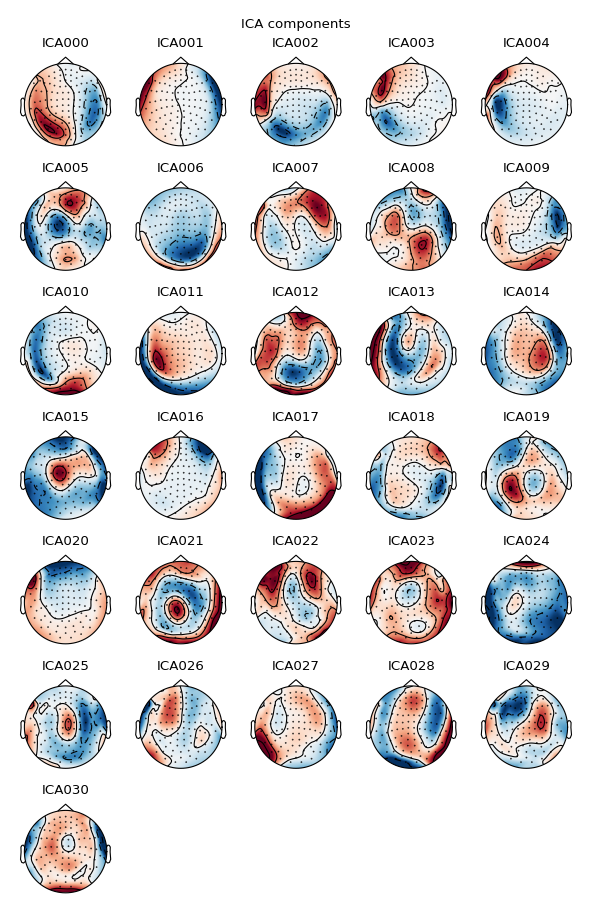

In [13]:
icacomps = mne.preprocessing.read_ica(cur_file)
if icacomps.exclude:
    print("Pre-selected components: {0:s}".format(', '.join(map(str, icacomps.exclude))))
    icacomps.exclude_old = icacomps.exclude
    icacomps.exclude = []
if not icacomps.exclude:
    print('Old components copied to .exclude_old. \n.exclude-field cleared')    

raw = mne.io.Raw(cur_raw_file, preload=True)

ecg_picks = mne.pick_types(raw.info, meg=False, eeg=False, eog=False, ecg=True,
               stim=False, exclude='bads')[0]
eog_picks = mne.pick_types(raw.info, meg=False, eeg=False, ecg=False, eog=True,
               stim=False, exclude='bads')[0]  ##changed back from 1 
meg_picks = mne.pick_types(raw.info, meg=True, eeg=True, eog=False, ecg=False,
                   stim=False, exclude='bads')               

ecg_evoked = mne.preprocessing.create_ecg_epochs(raw, tmin=-.5, tmax=.5,picks=meg_picks, verbose=False).average()
                               #ch_name=raw.ch_names[ecg_picks].encode('UTF8'))
eog_evoked = mne.preprocessing.create_eog_epochs(raw, tmin=-.5, tmax=.5,picks=meg_picks,
                       ch_name=raw.ch_names[eog_picks].encode('UTF8'), verbose=False).average()

# option to use one of the MEG-channels as pseudo-EOG-channel if the EOG-channel is too noisy
#eog_evoked = mne.preprocessing.create_eog_epochs(raw, tmin=-.5, tmax=.5,picks=meg_picks,
#                       ch_name="MEG0511", verbose=False).average()

# ica topos
source_idx = range(0, icacomps.n_components_)
ica_plot = icacomps.plot_components(source_idx, ch_type="mag") 

## ECG artefacts

<IPython.core.display.Javascript object>


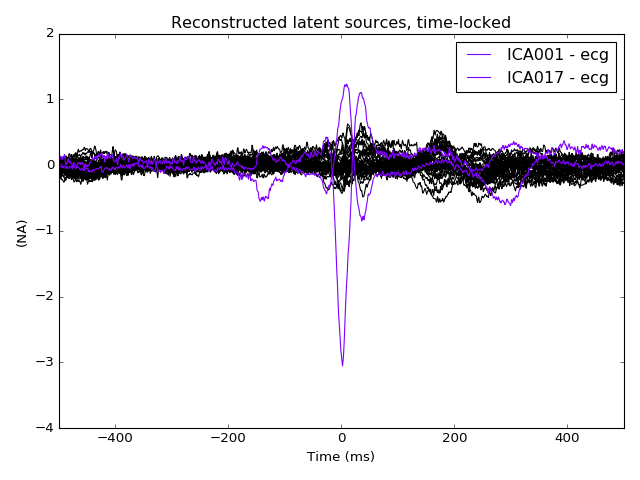

Transforming to ICA space (31 components)
Zeroing out 2 ICA components


<IPython.core.display.Javascript object>


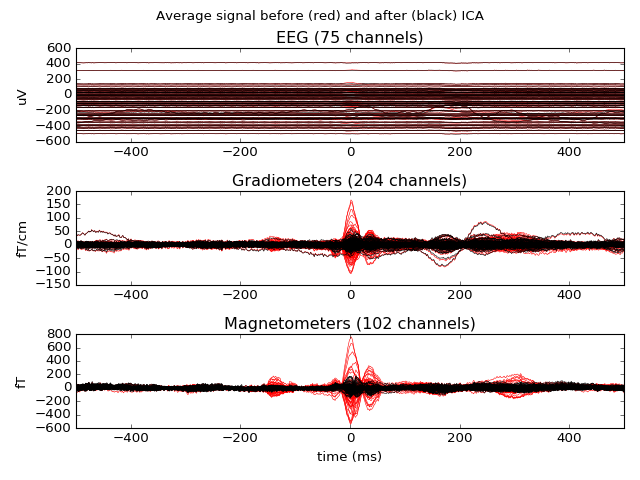

In [30]:
# [ECG] What components should be rejected as ECG comps? (Input them as a list; if none, leave empty)
ecg_exclude = [1, 17]

source_plot_ecg = icacomps.plot_sources(ecg_evoked, exclude=ecg_exclude)
clean_plot_ecg = icacomps.plot_overlay(ecg_evoked, exclude=ecg_exclude)


## Clean enough? [ECG]
Otherwise repeat previous step (aka. "What components should ...") with a different selection of components 

Once you're happy with your selection of components, proceed to the next step (aka. "Rejecting new selection ...")

In [24]:
# [ECG] Rejecting new selection of components (if any selected)

icacomps.labels_.update({'ecg': ecg_exclude, 'ecg/ECG-MAG': ecg_exclude})    

if ecg_source:
    icacomps.ecg_source = ecg_source
    source_plot_ecg.savefig(join(results_root, ica_file_id + '_ecg_source_vis.pdf'), format = 'pdf')
    clean_plot_ecg.savefig(join(results_root, ica_file_id + '_ecg_clean_vis.pdf'), format = 'pdf')
    print("Updated list [{0:s}] of ECG components to be excluded added to icacomps.ecg_source".
          format(', '.join(map(str, icacomps.ecg_source))))
else:
    print('*** No ECG components rejected ...')


Updated list 1, 17 of ECG components to be excluded added to icacomps.ecg_source


## EOG artefacts

<IPython.core.display.Javascript object>


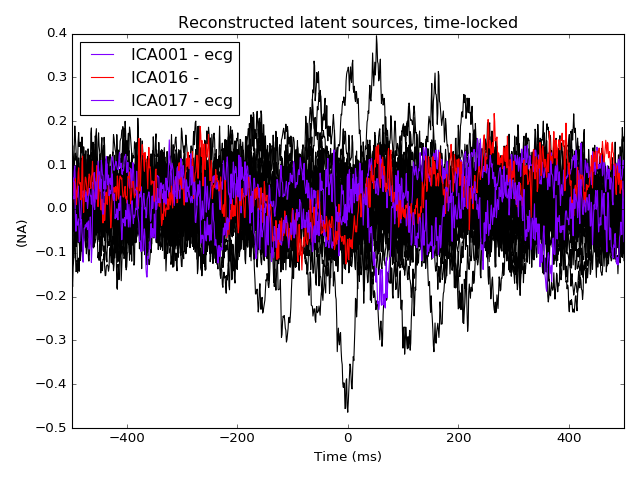

Transforming to ICA space (31 components)
Zeroing out 3 ICA components


<IPython.core.display.Javascript object>


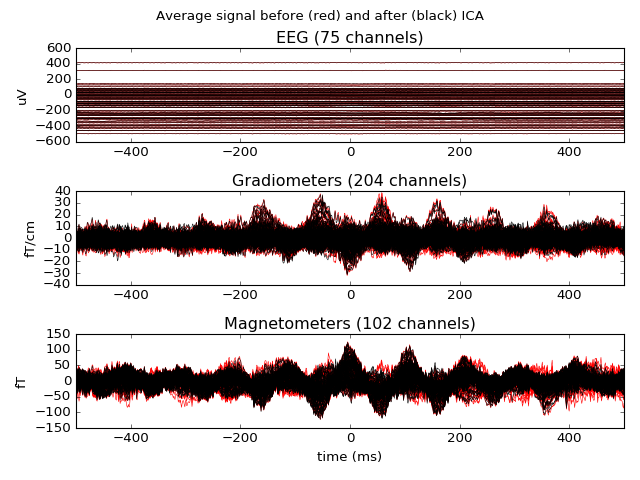

In [27]:
# [EOG] What components should be rejected as EOG comps? (Input them as a list; if none, leave empty)
eog_exclude = [16]

source_plot_eog = icacomps.plot_sources(eog_evoked, exclude=eog_exclude)
clean_plot_eog = icacomps.plot_overlay(eog_evoked, exclude=eog_exclude)



## Clean enough? [EOG]
Otherwise repeat previous step (aka. "[EOG] What components should ...") with a different selection of components 

Once you're happy with your selection of components, proceed to the next step (aka. " [EOG] Rejecting new selection ...")

In [28]:
# [ECG] Rejecting new selection of components (if any selected)

icacomps.labels_.update({'eog': eog_exclude, 'eog/EOG-MAG': eog_exclude}) 

if eog_source:
    icacomps.eog_source = eog_source
    source_plot_eog.savefig(join(results_root, ica_file_id + '_eog_source_vis.pdf'), format = 'pdf')
    clean_plot_eog.savefig(join(results_root, ica_file_id + '_eog_clean_vis.pdf'), format = 'pdf')
    print("Updated list [{0:s}] of EOG components to be excluded added to icacomps.eog_source".
          format(', '.join(map(str, icacomps.eog_source))))
else:
    print '*** No EOG components rejected...'
    

Updated list 16 of EOG components to be excluded added to icacomps.eog_source


## Excluding manually selected components and saving anew

In [35]:
icacomps.exclude = ecg_exclude + eog_exclude

if icacomps.exclude_old == icacomps.exclude:
    print("Old list of comps for exclusion is identical to the new one, hence nothing's done")    
else:
    print("*** Excluding the following components: {0:s}".format(', '.join(map(str, icacomps.exclude))))

    ica_plot.savefig(join(results_root, ica_file_id + 
                          ('_comps_eog{0:s}-ecg{1:s}.pdf'.
                           format('_'.join(map(str,eog_exclude)),
                                           '_'.join(map(str,ecg_exclude))))),format='pdf')

    raw_ica = icacomps.apply(raw)
    save_name = join(art_rej_root, ica_file_id + '_ica-raw.fif')
    #raw_ica.save(save_name, overwrite=False, verbose=False)
    # Option to overwrite existing files if necessary
    raw_ica.save(save_name, overwrite=True, verbose=False)
    print('Saved as {0:s}'.format(save_name))


*** Excluding the following components: 1, 17, 16
Transforming to ICA space (31 components)
Zeroing out 3 ICA components
Saved as /projects/MINDLAB2016_MR-PD-MCI/scratch/PD_MCI/ICA_eog_ecg/0002_ICD/rest_manual/rest_ica-vis-raw.fif
